# Shooting Method for Periodically-Forced Shallow Water Equations with Damping in One Dimension

## Import Packages

In [1]:
using LinearAlgebra
using BoundaryValueDiffEq
using SparseArrays
using Plots
using BenchmarkTools 

## Section 1: Introduction 

We apply the shooting method to solve the equations for the mode amplitudes resulting from the harmonic balance method applied to the shallow water equations. 

Shallow water equations model 

$$ \frac{\partial h}{\partial t} = - \frac{\partial u}{\partial x}  $$ 
$$ \frac{\partial u}{\partial t} = \frac{\partial h}{\partial x} - \gamma u - \gamma_3 u^3 + F_d(x) \sin(\omega_d t)$$

Harmonic balance anzats (single harmonic and same frequency for $h(x,t)$ and $u(x,t)$)

$$ h(x,t) = A(x) \cos(\omega_d t) + B(x) \sin(\omega_d t) $$
$$ u(x,t) = C(x) \cos(\omega_d t) + D(x) \sin(\omega_d t)$$

Resulting harmonic balance equations in linear case 

$$ A'(x) = \gamma C + \omega_d D$$ 
$$ B'(x) = \gamma D - \omega_d C - F_0(x)$$ 
$$ C'(x) = - \omega_d B$$ 
$$ D'(x) = \omega_d A$$ 

## Section 2: Shallow Water Equations 

### Section 1.2: Auxiliary Functions   

In [15]:
# set source function 
src(x) = 10*sin(3*pi*x) 
#src(x) = 1

# set right-hand side 
function rhs!(du, u, p, x)
    c, gamma, gamma3, omd = p 
    A = u[1]; B = u[2]; C = u[3]; D = u[4]
    du[1] = gamma*C+omd*D
    du[2] = gamma*D-omd*C-src(x) 
    du[3] = -omd*B 
    du[4] = omd*A
end

# set boundary conditions 
function bcperiodic!(residual, u, p, x)
    residual[1] = u(0)[1] -  u(1)[1]
    residual[2] = u(0)[2] -  u(1)[2]
    residual[3] = u(0)[3] -  u(1)[3]
    residual[4] = u(0)[4] -  u(1)[4]    
end

bcperiodic! (generic function with 1 method)

### Section 2.2: Set Parameters and Solve  

In [16]:
# set constants 
c = 1.
gamma = 5. 
gamma3 = 0  
omd = 5
p = [c, gamma, gamma3, omd]

# set domain size 
xspan = (0.,1.)

# set initial guess 
start = [0., 0., 0., 0.]

# define and solve the problem 
bvp = BVProblem(rhs!, bcperiodic!, start, xspan,p)
sol = solve(bvp, MIRK4(), dt = 0.05);

### Section 3.2: Post-Processing   

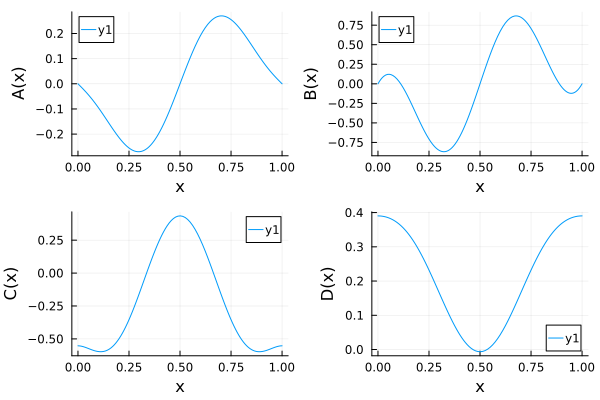

In [17]:
# plot u(x) and du/dx(x)
A = [u[1] for u in sol.u]
B = [u[2] for u in sol.u]
C = [u[3] for u in sol.u]
D = [u[4] for u in sol.u]
p1 = plot(sol.t, A, xlabel="x", ylabel = "A(x)") 
p2 = plot(sol.t, B, xlabel="x", ylabel = "B(x)") 
p3 = plot(sol.t, C, xlabel="x", ylabel = "C(x)") 
p4 = plot(sol.t, D, xlabel="x", ylabel = "D(x)")
plot(p1,p2,p3,p4,layout=(2,2))

### Section 4.2: Plot solution in space-time domain 

Construct solution in time domain by outer product of two vectors, one in space, the other in time. 

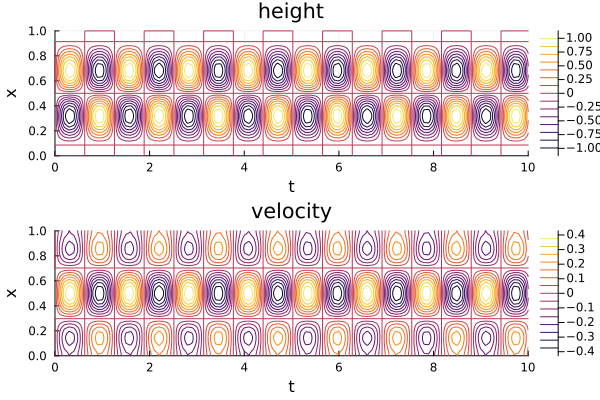

In [18]:
tend = 10; tstep = 0.1; 
tvec = 0:tstep:tend |> collect
ucost = sin.(omd*tvec)
usint = sin.(omd*tvec)
h = A*ucost' + B*usint'
u = C*ucost' + D*usint'
p1 = contour(tvec,sol.t,h,xlabel="t",ylabel="x",title="height")
p2 = contour(tvec,sol.t,u,xlabel="t",ylabel="x",title="velocity")
plot(p1,p2,layout=(2,1))

### Section 5.2: Solve ploblem for Various Frequency Values 

By adapting the [Example-2:-Solving-an-SDE-with-Different-Parameters](https://docs.sciml.ai/DiffEqDocs/stable/features/ensemble/#Example-2:-Solving-an-SDE-with-Different-Parameters). 

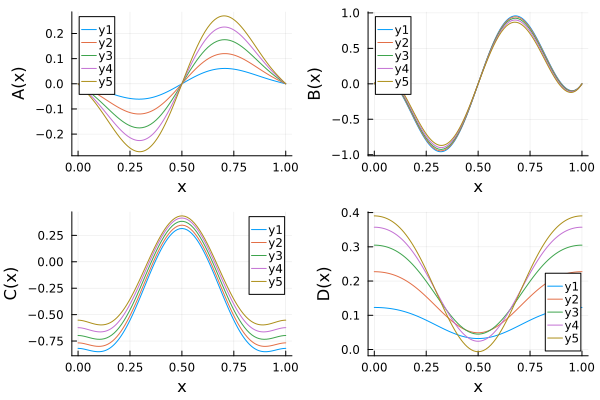

In [20]:
gammavec = [1.,2.,3.,4.,5.]
mypltb1 = plot();
mypltb2 = plot();
mypltb3 = plot();
mypltb4 = plot();
for gammai in gammavec
    p2 = [c, gammai, gamma3, omd]
    bvp = remake(bvp, p=p2);
    sol = solve(bvp, MIRK4(), dt = 0.05);
    A = [u[1] for u in sol.u]
    B = [u[2] for u in sol.u]
    C = [u[3] for u in sol.u]
    D = [u[4] for u in sol.u]
    mypltb1 = plot!(mypltb1, sol.t, A)  
    mypltb2 = plot!(mypltb2, sol.t, B)
    mypltb3 = plot!(mypltb3, sol.t, C)  
    mypltb4 = plot!(mypltb4, sol.t, D)
end 
p1 = plot(mypltb1,xlabel="x", ylabel = "A(x)")
p2 = plot(mypltb2,xlabel="x", ylabel = "B(x)")
p3 = plot(mypltb3,xlabel="x", ylabel = "C(x)")
p4 = plot(mypltb4,xlabel="x", ylabel = "D(x)")
plot(p1,p2,p3,p4,layout=(2,2))